## Import Library

In [1]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from deep_translator import GoogleTranslator
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from string import punctuation
import torch
from torch import nn, optim
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from jcopdl.callback import Callback, set_config
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
sw_indo = stopwords.words("indonesian") + list(punctuation)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Load data from CSV
df = pd.read_csv("youtube_comments.csv")
df.head()

,Unnamed: 0,author,published_at,comment,like
0,0,@MaulanaMaulanamaulana-eo5fl,2024-09-20T04:15:25Z,Ikn di buka untuk umum ...indah nya kota ikn d...,0
1,1,@daryanto07,2024-08-01T00:45:05Z,"Masuk akal nggak sih, mulai dibangun tahun 202...",0
2,2,@ArwanAhmad-z8g,2024-07-26T02:16:40Z,Ikn jalan terus hebat .semangat maju terus ind...,0
3,3,@harunindrapratama5497,2024-07-18T18:14:51Z,Orang bodoh penjilat,0
4,4,@istachondoni198,2024-07-18T10:27:29Z,setuju,0


# Preprocessing Data Crawling

## Translate

In [21]:
def translate_comment(comment):
    if len(comment) < 5000:
        return GoogleTranslator(source='auto', target='en').translate(comment)
    else:
        sentences = sent_tokenize(comment)
        return " ".join([GoogleTranslator(source='auto', target='en').translate(sentence) for sentence in sentences])

In [22]:
# df["en_comment"] = df.comment.apply(translate_comment)

In [23]:
# df.to_csv("en_comments.csv")

## Drop Missing Value

In [25]:
# df.isnull().sum()

In [27]:
# df.dropna(inplace=True)

In [29]:
# df.isnull().sum()

## Cleaning

In [30]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphanumeric characters
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

In [31]:
# df.en_comment = df.en_comment.apply(clean_text)
# df.comment = df.comment.apply(clean_text)

In [32]:
# df.to_csv("clean_comments.csv", index=False)

## Labelling

In [33]:
def labeling(comment):
    sentiment = SentimentIntensityAnalyzer()
    x = sentiment.polarity_scores(comment)
    # print(x)
    if x["compound"] >= 0:
        return "positif"
    else:
        return "negatif"
    # return "positif" if x["compound"] >= 0 else "negatif"

In [34]:
# df["label"] = df["en_comment"].apply(labeling)

In [ ]:
# df = df.drop(columns=["author", "published_at", "like", "en_comment"])

In [36]:
# df.to_csv("label_comment.csv")

# Load dataset

In [4]:
# Load data from CSV
data = pd.read_csv("label_comment.csv")

## Stemming

In [ ]:
# Load data from CSV
# data = pd.read_csv("stem_comment.csv")

In [44]:
# factory = StemmerFactory()
# stemmer = factory.create_stemmer()
# stemmer.stem()
# def stem(text):
#     return stemmer.stem(text.lower())
# data["comment"] = data["comment"].apply(stem)

In [12]:
data.to_csv("stem_comment.csv", index=False)

In [6]:
sentences = data["comment"].values
labels = data["label"].values

# Tokenisasi

In [7]:
def tokenize_and_pad(sentences, vocab, pad_length=10):
    tokenized = [[vocab[word] if word in vocab else vocab['<UNK>'] for word in word_tokenize(sentence.lower())] for sentence in sentences]
    padded = [seq[:pad_length] + [vocab['<PAD>']] * (pad_length - len(seq)) if len(seq) < pad_length else seq[:pad_length] for seq in tokenized]
    return padded

# Vocabulary

In [8]:
# Vocabulary preparation
all_words = set(word for sentence in sentences for word in word_tokenize(sentence.lower()))
vocab = {word: idx + 2 for idx, word in enumerate(all_words)}  # Start index from 2
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

# Encoding

In [9]:
# Encode sentences and labels
encoded_sentences = tokenize_and_pad(sentences, vocab)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)


# Dataset Splitting

In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(encoded_sentences, encoded_labels, test_size=0.2, random_state=42)

In [11]:
# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# Dataset dan Dataloader

In [12]:
# Dataloaders
train_dataset = SentimentDataset(X_train, y_train)
test_dataset = SentimentDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [13]:
# GRU Model
class GRUSentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(GRUSentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, hidden = self.gru(embedded)
        out = self.fc(hidden.squeeze(0))
        return out

# Training preparation

In [14]:
# Model initialization
vocab_size = len(vocab)
embedding_dim = 32
hidden_dim = 32
output_dim = len(label_encoder.classes_)
# dropout = 0.2

In [15]:
model = GRUSentimentModel(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
callback = Callback(model, outdir="model")

In [16]:

from tqdm.auto import tqdm
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature) # feedforward
        loss = criterion(output, target)
        if mode == "train":
            loss.backward() # backpropragation
            optimizer.step() # update weight
            optimizer.zero_grad()
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

# Training

Train:   0%|          | 0/39 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6766 | Test_cost  = 0.6241 | Train_score = 0.5853 | Test_score = 0.7480 |


Train:   0%|          | 0/39 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.5991 | Test_cost  = 0.5617 | Train_score = 0.7371 | Test_score = 0.7480 |
==> EarlyStop patience =  1 | Best test_score: 0.7480


Train:   0%|          | 0/39 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.5646 | Test_cost  = 0.5535 | Train_score = 0.7407 | Test_score = 0.7480 |
==> EarlyStop patience =  2 | Best test_score: 0.7480


Train:   0%|          | 0/39 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.5551 | Test_cost  = 0.5495 | Train_score = 0.7407 | Test_score = 0.7496 |


Train:   0%|          | 0/39 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.5462 | Test_cost  = 0.5457 | Train_score = 0.7416 | Test_score = 0.7463 |
==> EarlyStop patience =  1 | Best test_score: 0.7496


Train:   0%|          | 0/39 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.5360 | Test_cost  = 0.5406 | Train_score = 0.7432 | Test_score = 0.7528 |


Train:   0%|          | 0/39 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.5224 | Test_cost  = 0.5364 | Train_score = 0.7473 | Test_score = 0.7431 |
==> EarlyStop patience =  1 | Best test_score: 0.7528


Train:   0%|          | 0/39 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.5074 | Test_cost  = 0.5332 | Train_score = 0.7550 | Test_score = 0.7463 |
==> EarlyStop patience =  2 | Best test_score: 0.7528


Train:   0%|          | 0/39 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.4897 | Test_cost  = 0.5304 | Train_score = 0.7619 | Test_score = 0.7285 |
==> EarlyStop patience =  3 | Best test_score: 0.7528


Train:   0%|          | 0/39 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.4692 | Test_cost  = 0.5287 | Train_score = 0.7774 | Test_score = 0.7382 |
==> EarlyStop patience =  4 | Best test_score: 0.7528


Train:   0%|          | 0/39 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.4497 | Test_cost  = 0.5263 | Train_score = 0.7904 | Test_score = 0.7203 |
==> EarlyStop patience =  5 | Best test_score: 0.7528
==> Execute Early Stopping at epoch: 11 | Best test_score: 0.7528
==> Best model is saved at model


/home/zaens/miniconda3/envs/MachineLearning/lib/python3.12/site-packages/jcopdl/callback/_callback.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load

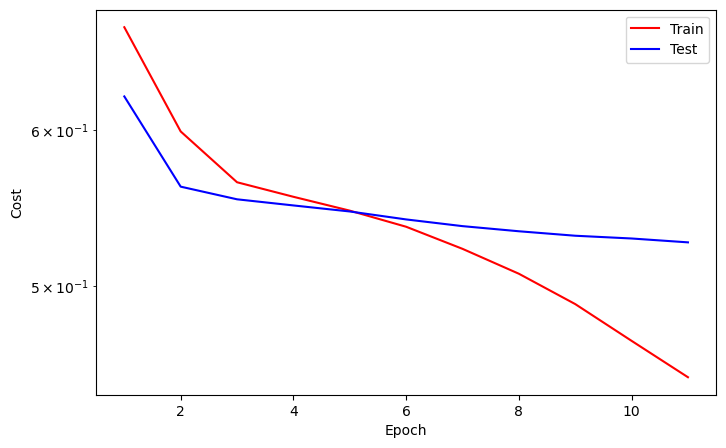

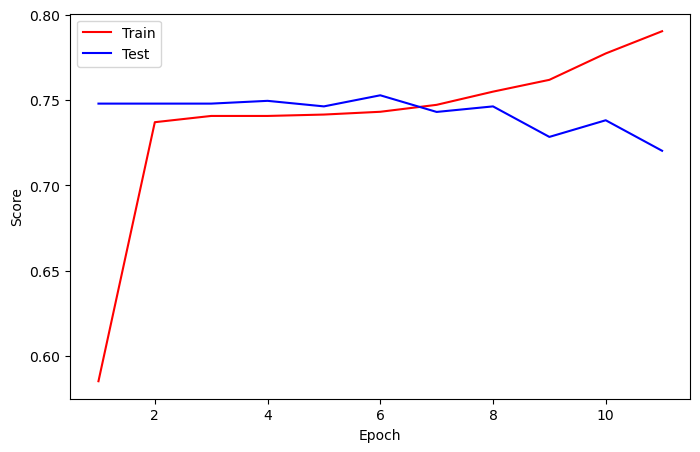

In [17]:
while True:
    train_cost, train_score = loop_fn("train", train_dataset, train_loader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_dataset, test_loader, model, criterion, optimizer, device)
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)
    # Save CheckPoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Predict

In [17]:
feature, target = next(iter(test_loader))
feature, target = feature.to(device), target.to(device)

In [18]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [16]:
weights = torch.load("model/gru/weights_best.pth", map_location="cpu")
weights

/tmp/ipykernel_5602/1323785685.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("model/gru/weights_best.pth", map_location="cpu")


OrderedDict([('rnn.weight_ih_l0',
              tensor([[-0.0056,  0.0612, -0.0726,  ..., -0.1048,  0.0796, -0.0560],
                      [-0.1030,  0.0686, -0.0845,  ...,  0.0879, -0.1103,  0.0185],
                      [-0.0264, -0.0602, -0.0440,  ...,  0.1342, -0.0408, -0.0525],
                      ...,
                      [ 0.0236,  0.0288,  0.0818,  ...,  0.0051,  0.0539,  0.0180],
                      [ 0.0622,  0.0159,  0.0562,  ...,  0.1116,  0.0802, -0.0600],
                      [-0.0972, -0.0086, -0.0506,  ...,  0.0220, -0.0039, -0.0051]])),
             ('rnn.weight_hh_l0',
              tensor([[ 0.1060, -0.1247, -0.0950,  ...,  0.1079, -0.0933, -0.0246],
                      [-0.0683, -0.0620,  0.0491,  ...,  0.0582,  0.1096,  0.0062],
                      [ 0.1110, -0.0585,  0.0916,  ...,  0.0454,  0.0958, -0.0320],
                      ...,
                      [ 0.1435,  0.0694,  0.0215,  ...,  0.1129,  0.1488,  0.0094],
                      [-0.0742, -0.